<a href="https://colab.research.google.com/github/NithinNarayanan07/Computer-Vision/blob/main/CV_Harris_Corner_19136.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [123]:
from skimage import transform
from skimage import data
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from skimage.color import rgb2gray
import random
import tensorflow as tf

import cv2
from pylab import *
from google.colab.patches import cv2_imshow
from urllib.request import urlopen

def url_to_image(url, readFlag=cv2.IMREAD_COLOR):
    resp = urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, readFlag)
    return image

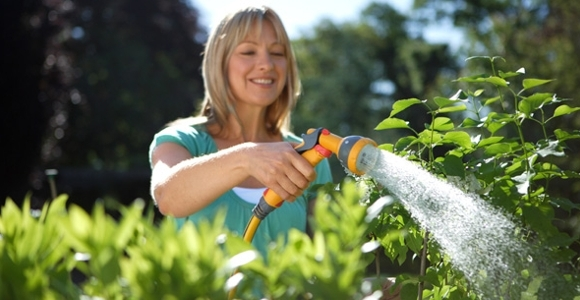

In [124]:

path="https://github.com/NithinNarayanan07/Computer-Vision/blob/main/Database/watering_0.jpg?raw=true"
img = url_to_image(path)
cv2_imshow(img)

1)Converting image to grayscale

Using flags=0 inside imread defaulty converts image into gray-scale

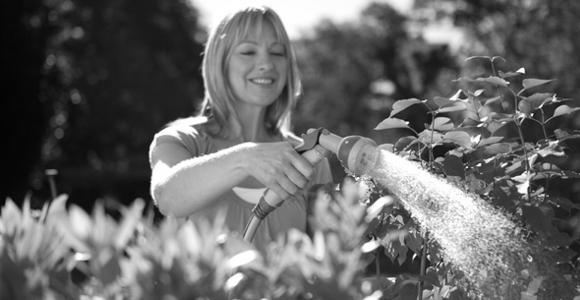

In [125]:
#  img = cv2.imread(img,flags=0)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2_imshow(img)

Applying Gaussian Filter to Smooth out Noise

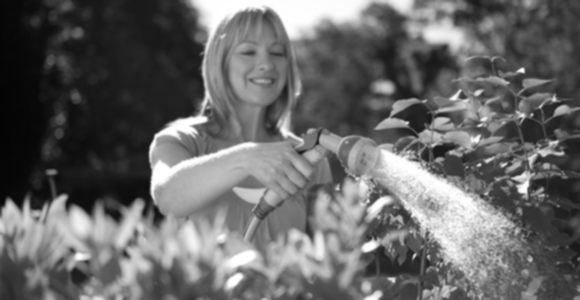

In [126]:
img_blur = cv2.GaussianBlur(img,(3,3), sigmaX=0, sigmaY=0) 
cv2_imshow(img_blur)

Applying Sobel Operator to find x and y gradients for every pixel in the grayscale image

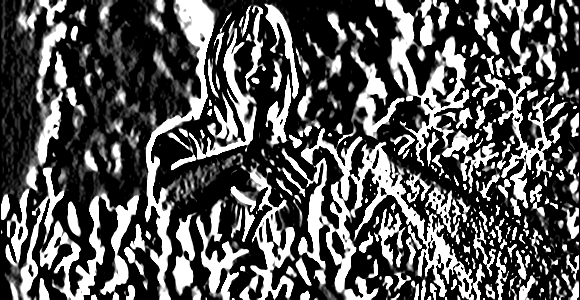

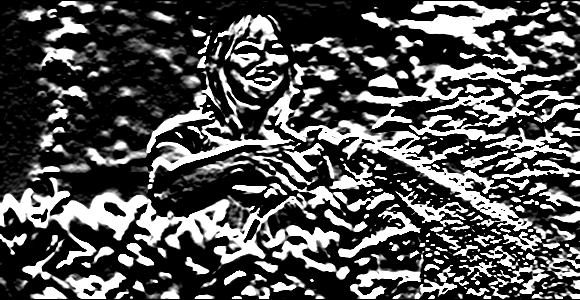

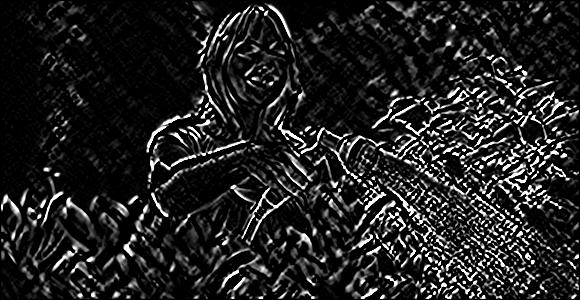

In [127]:
# Sobel Edge Detection
sobelx = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=5) # Sobel Edge Detection on the X axis
sobely = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=0, dy=1, ksize=5) # Sobel Edge Detection on the Y axis
sobelxy = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=5) # Combined X and Y Sobel Edge Detection

# Display Sobel Edge Detection Images
cv2_imshow(sobelx)


cv2_imshow(sobely)


cv2_imshow(sobelxy)


4.  For each pixel p in the grayscale image, consider a 3×3 window around it and compute the corner strength function. Call this its Harris value.

In [128]:
gray = np.float32(img_blur)


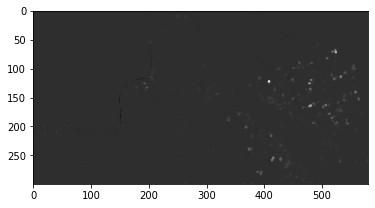

In [129]:
# Detect corners 
dst = cv2.cornerHarris(gray, 2, 3, 0.04)

# Dilate corner image to enhance corner points
dst = cv2.dilate(dst,None)

plt.imshow(dst, cmap='gray')

Q5)Find all pixels that exceed a certain threshold and are the local maxima within a certain window (to prevent redundant dupes of features)

6) Display the detected corners on the input image

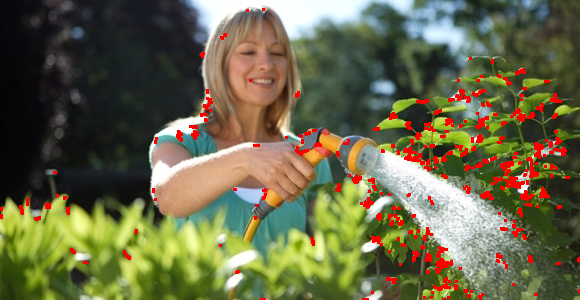

In [130]:
def Harris_Corner(img):
  # # setting to 32-bit floating point
  operatedImage = np.float32(img)

  # # apply the cv2.cornerHarris method
  # # to detect the corners with appropriate
  # # values as input parameters
  dest = cv2.cornerHarris(operatedImage, 2, 5, 0.07)

  # Results are marked through the dilated corners
  dest = cv2.dilate(dest, None)

  image[dest > 0.01 * dest.max()]=[0, 0, 255]
  return image
  
  # cv2_imshow(image)
image = url_to_image(path)
image=Harris_Corner(img_blur)
cv2_imshow(image)

# Harris Corner from Scratch

In [131]:
SOBEL_X = np.array((
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]), dtype="int32")

# Sobel y-axis kernel
SOBEL_Y = np.array((
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1]), dtype="int32")

# Gaussian kernel
GAUSS = np.array((
    [1/16, 2/16, 1/16],
    [2/16, 4/16, 2/16],
    [1/16, 2/16, 1/16]), dtype="float64")

In [132]:
def convolve(img, kernel):
    """
    Convolve function for odd dimensions.
    IT CONVOLVES IMAGES
    """
    if kernel.shape[0] % 2 != 1 or kernel.shape[1] % 2 != 1:
        raise ValueError("Only odd dimensions on filter supported")

    img_height = img.shape[0]
    img_width = img.shape[1]
    pad_height = kernel.shape[0] // 2
    pad_width = kernel.shape[1] // 2
    
    pad = ((pad_height, pad_height), (pad_height, pad_width))
    g = np.empty(img.shape, dtype=np.float64)
    img = np.pad(img, pad, mode='constant', constant_values=0)
    # Do convolution
    for i in np.arange(pad_height, img_height+pad_height):
        for j in np.arange(pad_width, img_width+pad_width):
            roi = img[i - pad_height:i + pad_height +
                      1, j - pad_width:j + pad_width + 1]
            g[i - pad_height, j - pad_width] = (roi*kernel).sum()

    if (g.dtype == np.float64):
        kernel = kernel / 255.0
        kernel = (kernel*255).astype(np.uint8)
    else:
        g = g + abs(np.amin(g))
        g = g / np.amax(g)
        g = (g*255.0)
    return g


5.Find all pixels that exceed a certain threshold and are the local maxima within a certain window (to prevent redundant dupes of features)

In [133]:
def Harris(img,threshold):
  img_cpy=img.copy()
  img1_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  dx=convolve(img1_gray,SOBEL_X)
  dy=convolve(img1_gray,SOBEL_Y)
  dx2=np.square(dx)
  dy2=np.square(dy)
  dxdy=dx*dy #cross filtering
  # gauss filter for all directions (x,y,cross axis)
  g_dx2 = convolve(dx2, GAUSS)
  g_dy2 = convolve(dy2, GAUSS)
  g_dxdy = convolve(dxdy, GAUSS)
  harris = g_dx2*g_dy2 - np.square(g_dxdy) - 0.12*np.square(g_dx2 + g_dy2) # r(harris) = det - k*(trace**2)
  # Normalizing inside (0-1)
  cv2.normalize(harris, harris, 0, 1, cv2.NORM_MINMAX)
  #Q5Q5
  #Finding all points above threshold (non max suppression line)
  loc = np.where(harris >= threshold)
  # drawing filtered points
  for pt in zip(*loc[::-1]):
      cv2.circle(img_cpy, pt, 3, (0, 0, 255), -1)
  
  return img_cpy,g_dx2,g_dy2,dx,dy,loc
img=url_to_image(path)  
corners,g_dx2,g_dy2,dx,dy,loc = Harris(img,0.65)  

(Text(0.5, 1.0, 'Harris Corner Output'),
 ([], <a list of 0 Text major ticklabel objects>),
 ([], <a list of 0 Text major ticklabel objects>))

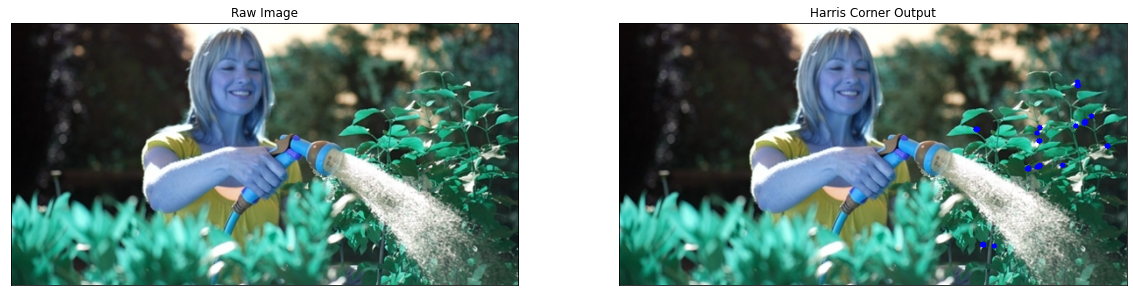

In [134]:
plt.figure(figsize=(20, 20))
plt.subplot(121), plt.imshow(img)
plt.title("Raw Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(corners)
plt.title("Harris Corner Output"), plt.xticks([]), plt.yticks([])

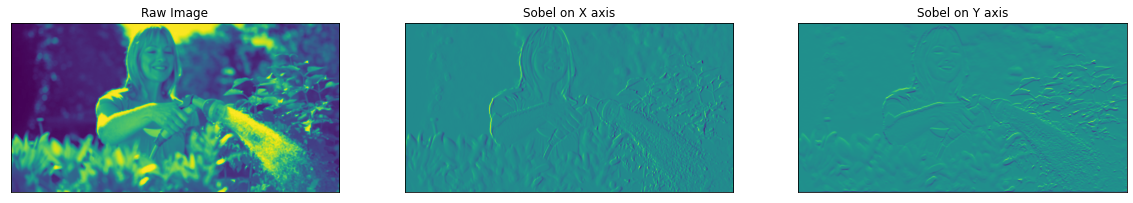

In [135]:
# display raw & filtered images
plt.figure(figsize=(20, 20))
plt.subplot(131), plt.imshow(img_blur)
plt.title("Raw Image"), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(dx)
plt.title("Sobel on X axis"), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(dy)
plt.title("Sobel on Y axis"), plt.xticks([]), plt.yticks([])
plt.show()

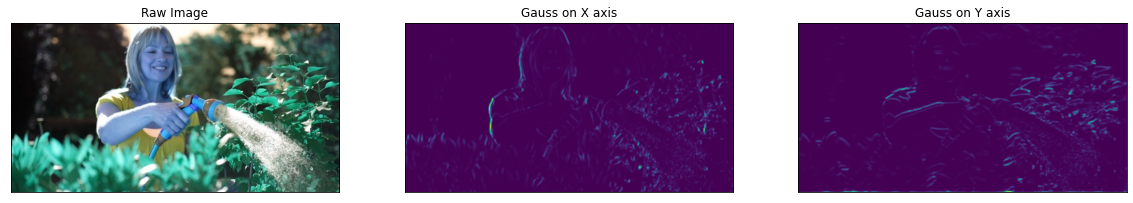

In [136]:
plt.figure(figsize=(20, 20))
plt.subplot(131), plt.imshow(img)
plt.title("Raw Image"), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(g_dx2)
plt.title("Gauss on X axis"), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(g_dy2)
plt.title("Gauss on Y axis"), plt.xticks([]), plt.yticks([])
plt.show()

6) Display the detected corners on the input image

(Text(0.5, 1.0, 'Harris Corner Output'),
 ([], <a list of 0 Text major ticklabel objects>),
 ([], <a list of 0 Text major ticklabel objects>))

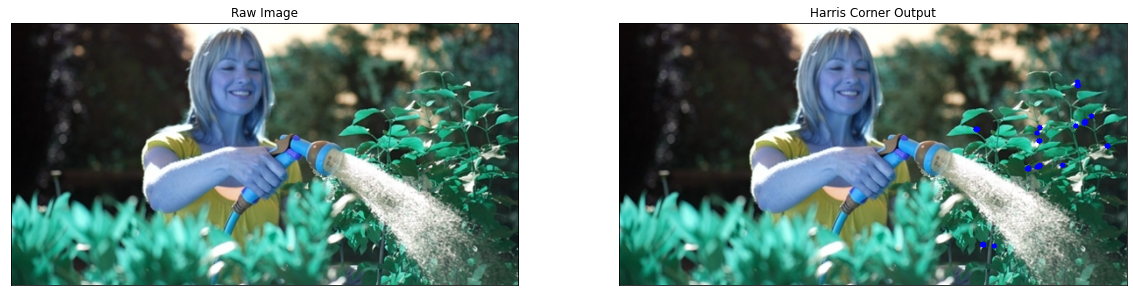

In [137]:
plt.figure(figsize=(20, 20))
plt.subplot(121), plt.imshow(img)
plt.title("Raw Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(corners)
plt.title("Harris Corner Output"), plt.xticks([]), plt.yticks([])